## Dynamics

Dynamics | $\partial_{\tau}x_i=$ |
| :--------: | :-------: |
Biochemical | $F -B x_i - R \sum_j A_{ij} x_i x_j$ |
Epidemics | $-B x_i + R \sum_j A_{ij} (1-x_i)x_j$ |
Neuronal | $-B x_i + C \tanh x_i + R \sum_j A_{ij} \tanh x_j$ |
Population | $-B x_i^{b} + R \sum_j A_{ij} x_j^a$ |
Synchronization | $\omega_i + R \sum_j A_{ij} \sin(x_j-x_i)$ |

In [1]:
%load_ext autoreload
%autoreload 2

## Importing

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
from train_and_eval import eval_model
import sympytorch


storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [7]:
import random

def set_pytorch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
    
set_pytorch_seed(0)

In [8]:
config = load_config("./configs/config_pred_deriv/config_ic3/config_epidemics.yml")
config['t_span'] = [0, 1]
exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name="test_mult_9"
)

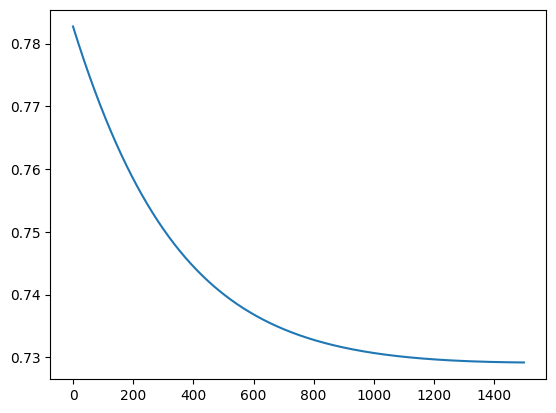

In [36]:
data = exp.training_set.raw_data_sampled[1].detach().cpu().numpy()
plt.plot(data[:, 68, :])

In [9]:
exp.epochs = 10
exp.run()

[I 2025-06-28 14:42:12,412] A new study created in Journal with name: model-epidemics-gkan-test_mult_9


Trial 0: num params: 276


[I 2025-06-28 14:42:29,232] Trial 0 finished with value: 0.013182164169847965 and parameters: {'lr': 0.0028057582076672534, 'lamb': 1.0, 'batch_size': 16, 'use_orig_reg': True, 'lamb_g_net': 8.63200816860254e-06, 'lamb_h_net': 8.629132190071855e-06, 'grid_size_g_net': 5, 'spline_order_g_net': 3, 'range_limit_g_net': 7, 'mu_1_g_net': 0.8, 'mu_2_g_net': 0.1, 'hidden_dim_g_net': 5, 'grid_size_h_net': 18, 'spline_order_h_net': 1, 'range_limit_h_net': 2, 'mu_1_h_net': 0.2, 'mu_2_h_net': 0.4, 'hidden_dim_h_net': 3}. Best is trial 0 with value: 0.013182164169847965.


In [8]:
config_pop = load_config("./configs/config_pred_deriv/config_ic1/config_population_mpnn.yml")
# config_pop["t_eval_steps"] = 1000
# config_pop["t_span"] = [0, 10]

exp = ExperimentsMPNN(
    config=config_pop,
    n_trials=1,
    study_name='test_mult_3'
)

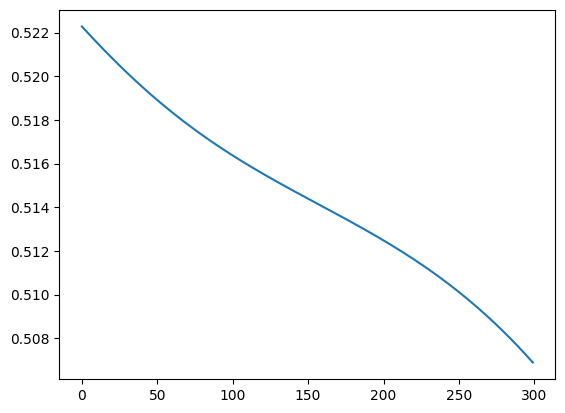

In [5]:
data = exp.training_set.raw_data_sampled[0].detach().cpu().numpy()
plt.plot(data[:, 6, :])

In [22]:
exp.training_set.raw_data_sampled.min()

tensor(-0.9936, device='cuda:0')

In [9]:
exp.epochs = 10
exp.run()

[I 2025-06-28 15:04:55,317] A new study created in Journal with name: model-population-mpnn-test_mult_3


Trial 0: num params: 258


[I 2025-06-28 15:05:07,462] Trial 0 finished with value: 0.0017352376598864794 and parameters: {'lr': 0.0028057582076672534, 'lamb': 0.0, 'batch_size': 16, 'n_hidden_layers_g_net': 1, 'hidden_dims_g_net': 16, 'af_g_net': 'softplus', 'drop_p_g_net': 0.04160439645256607, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 64, 'af_h_net': 'relu', 'drop_p_h_net': 0.00047687854154826123}. Best is trial 0 with value: 0.0017352376598864794.


## Utils

In [4]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE

import optuna

import warnings
warnings.filterwarnings("ignore")

In [5]:
from sympy import latex
from torch.utils.data import DataLoader

def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-3, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    symb = symb.eval()
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-3, scaler = None, inverse_scale=False, method='scipy_solver'):
    
    # total_len = len(dataset)
    # test_set = dataset[int(0.9*total_len):]
    
    symb = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        integration_method=method
    )
    
    collate_fn = lambda samples_list: samples_list
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True, collate_fn=collate_fn)
    
    test_loss = eval_model(
        model=symb,
        valid_loader=test_loader,
        criterion=torch.nn.L1Loss(),
        scaler=scaler,
        inverse_scale=inverse_scale,
        pred_deriv=False
    )
    
    return test_loss


def get_test_set(dynamics, seed=12345, device='cuda', input_range = (0, 1), **integration_kwargs):
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = [0, 1],
        t_eval_steps=300,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]


def build_model_from_file(model_path, message_passing, include_time, method='dopri5', adjoint=False):
    best_params_file = f"{model_path}/best_params.json"
    best_state_path = f"{model_path}/gkan/state_dict.pth"
    
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    # g_net
    g_net = KAN(
        layers_hidden=[2, best_hyperparams['hidden_dim_g_net'], 1],
        grid_size=best_hyperparams['grid_size_g_net'],
        spline_order=best_hyperparams['spline_order_g_net'],
        grid_range=[-best_hyperparams['range_limit_g_net'], best_hyperparams['range_limit_g_net']],
        mu_1=best_hyperparams['mu_1_g_net'],
        mu_2=best_hyperparams['mu_2_g_net'],
        device='cuda',
        compute_mult=True,
        store_act=True
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    
    # h_net
    h_net = KAN(
        layers_hidden=[in_dim_h, best_hyperparams['hidden_dim_h_net'], 1],
        grid_size=best_hyperparams['grid_size_h_net'],
        spline_order=best_hyperparams['spline_order_h_net'],
        grid_range=[-best_hyperparams['range_limit_h_net'], best_hyperparams['range_limit_h_net']],
        mu_1=best_hyperparams['mu_1_h_net'],
        mu_2=best_hyperparams['mu_2_h_net'],
        device='cuda',
        compute_mult=True,
        store_act=True
    )
    
    gkan = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = GKAN_ODE(
        conv=gkan,
        model_path='./saved_models_optuna/tmp',
        lmbd_g=best_hyperparams['lamb_g_net'],
        lmbd_h=best_hyperparams['lamb_h_net'],
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False, map_location=torch.device('cuda')))
    
    return model


def post_process_gkan(
    g_symb, 
    h_symb, 
    model_path, 
    test_set, 
    message_passing=False, 
    include_time=False,
    atol=1e-5,
    rtol=1e-3,
    method='dopri5',
    scaler=None,
    inverse_scale=False,
    adjoint=True
):
    test_loss_symb = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    print(f"Test loss of symbolic formula: {test_loss_symb}")
    
    # Loading best model
    best_model = build_model_from_file(
        model_path=model_path,
        message_passing=message_passing,
        include_time=include_time,
        method=method,
        adjoint=adjoint
    )
    
    tot_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
    print(f"Number of model's parameters: {tot_params}")
    
    best_model = best_model.eval()
    test_loss_model = get_symb_test_error(
        g_symb=best_model.conv.model.g_net,
        h_symb=best_model.conv.model.h_net,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    print(f"Test loss best model: {test_loss_model}")

    y_true = test_set[0].y.detach().cpu().numpy()
    y_pred = best_model(snapshot = test_set[0]).detach().cpu().numpy()
    
    return y_true, y_pred


def make_callable(expr):
    free_syms = expr.free_symbols
    if not free_syms:
        # Expression is constant
        const_value = float(expr)
        return lambda x: torch.full((x.shape[0], 1), const_value, dtype=x.dtype, device=x.device)

    sym_module = sympytorch.SymPyModule(expressions=[expr])
    syms = {str(s) for s in free_syms}
    if {'x_i', 'x_j'} <= syms:
        return lambda x: sym_module(x_i=x[:, 0], x_j=x[:, 1])
    elif 'x_i' in syms:
        return lambda x: sym_module(x_i=x[:, 0])
    elif 'x_j' in syms:
        return lambda x: sym_module(x_j=x[:, 1])
    else:
        raise ValueError(f"Unexpected symbols in expression: {free_syms}")


def get_error_spline_wise(model_path, test_set, theta=0.1, atol=1e-5, rtol=1e-3, sample_size=10000, seed=42):
    symb_spline_wise, symb_g, symb_h = fit_model(
        n_h_hidden_layers=2,
        n_g_hidden_layers=2,
        model_path=model_path,
        theta=theta,
        message_passing=False,
        include_time=False,
        sample_size=sample_size,
        seed=seed
    )
    
    # print(latex(quantise(symb_spline_wise)))
    
    if isinstance(symb_g, int):
        symb_g = sp.sympify(symb_g)
        
    if isinstance(symb_h, int):
        symb_h = sp.sympify(symb_h)
    
    g_symb = make_callable(symb_g)
    h_symb = make_callable(symb_h)
    
    test_loss_splinewise = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=False,
        include_time=False,
        method="dopri5",
        atol=atol,
        rtol=rtol
    )
    
    symb_model = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=False,
        include_time=False,
        atol=atol,
        rtol=rtol,
        integration_method="dopri5"
    )
    
    y_true = test_set[0].y.detach().cpu().numpy()
    y_pred = symb_model(snapshot = test_set[0]).detach().cpu().numpy()
    
    return quantise(symb_spline_wise), test_loss_splinewise, y_true, y_pred


def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def valid_symb_model(valid_set, model_path_gkan, test_set, n_trials=50):
    valid_set = valid_set
    alpha_range = [1e-5, 0.1]
    theta_range = [1e-5, 0.5]
    
    def objective(trial):
        theta = trial.suggest_float('theta', theta_range[0], theta_range[1], log=True)
        alpha = trial.suggest_float('alpha', alpha_range[0], alpha_range[1], log=True)
        _, val_loss = get_error_spline_wise(
            model_path=model_path_gkan,
            test_set=valid_set,
            theta=theta,
            use_sindy=False,
            alpha = alpha
        )   
        return val_loss
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    best_theta, best_alpha = study.best_params['theta'], study.best_params['alpha']
    expr, test_loss = get_error_spline_wise(
            model_path=model_path_gkan,
            test_set=test_set,
            theta=best_theta,
            use_sindy=False,
            alpha=best_alpha
    )
    
    print(f"Test error: {test_loss}")
    
    return expr

## LB losses


### Kuramoto

In [6]:
kur_config = load_config("./configs/config_pred_deriv/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    seed = 12345,
    device='cuda',
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Kuramoto: {test_loss}")


Kuramoto: 0.0014358223415911198


### Epidemics

In [7]:
epid_config = load_config("./configs/config_pred_deriv/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    seed = 12345,
    device='cuda',
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Epidemics: {test_loss}")


Epidemics: 3.469900548225269e-05


### Population

In [8]:
pop_config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    seed = 12345,
    device='cuda',
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']    
)

g_symb = lambda x: 0.2*torch.pow(x[:, 1].unsqueeze(-1), 3)
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Population: {test_loss}")


Population: 5.306350067257881e-05


### Biochemical

In [9]:
bio_config = load_config("./configs/config_pred_deriv/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    seed = 12345,
    device='cuda',
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Biochemical: {test_loss}")

Biochemical: 2.9264498152770102e-05


## Symb Reg

### Biochemical


#### IC=1

In [ ]:
model_path_gkan = "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_6/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb, symb_g, symb_h = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [10]:
gkan_symb

\sum_{j}( -0.49992076*x_i*x_j) - 0.50022495*x_i + 1.0000589

In [ ]:
g_symb_torch = sympytorch.SymPyModule(expressions=[symb_g])
h_symb_torch = sympytorch.SymPyModule(expressions=[symb_h])

g_symb = lambda x: g_symb_torch(x_i = x[:, 0], x_j = x[:, 1])
h_symb = lambda x: h_symb_torch(x_i = x[:, 0])

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_6/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

In [16]:
model_path_gkan = "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_12/0/gkan"

splie_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=BIO,
    theta=0.1
)

In [17]:
splie_wise

\sum_{j}(-0.49*x_i*x_j + 0.01*x_j) - 0.5*x_i + 1.0

In [18]:
print(error)

0.011854587122797966


### Kuramoto

#### IC=1

In [31]:
model_path_gkan = "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_6/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb, symb_g, symb_h = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [32]:
gkan_symb

\sum_{j}( -0.4995985*sin(x_i - x_j)) - 1.2280017e-5*exp(x_i) + 2.00262

In [33]:
quantise(gkan_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [ ]:
g_symb_torch = sympytorch.SymPyModule(expressions=[symb_g])
h_symb_torch = sympytorch.SymPyModule(expressions=[symb_h])

g_symb = lambda x: g_symb_torch(x_i = x[:, 0], x_j = x[:, 1])
h_symb = lambda x: h_symb_torch(x_i = x[:, 0])

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_7/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

In [19]:
model_path_gkan = "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_12/0/gkan"

splie_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=KUR,
    theta=0.1
)

Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,3)
Pruning node (0,4)
Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,3)
Pruning node (0,4)
Pruning node (0,5)


In [20]:
splie_wise

\sum_{j}(-0.5*sin(-1.0*x_i + 1.0*x_j + 3.14)) + 2.0

In [21]:
print(f"Error: {error}")

Error: 0.003437255509197712


### Epidemics

#### IC=1

In [39]:
model_path_gkan = "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_6/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb, symb_g, symb_h = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [40]:
gkan_symb

\sum_{j}( 0.500583*x_j*(0.9996741 - x_i)) - 0.49962592*x_i

In [41]:
quantise(gkan_symb)

\sum_{j}(0.5*x_j*(1.0 - x_i)) - 0.5*x_i

In [ ]:
g_symb_torch = sympytorch.SymPyModule(expressions=[symb_g])
h_symb_torch = sympytorch.SymPyModule(expressions=[symb_h])

g_symb = lambda x: g_symb_torch(x_i = x[:, 0], x_j = x[:, 1])
h_symb = lambda x: h_symb_torch(x_i = x[:, 0])


y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_6/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0001484551903558895
Number of model's parameters: 237
Test loss best model: 9.477345884079114e-05


In [10]:
model_path_gkan = "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_12/0/gkan"

splie_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=EPID,
    theta=0.1
)

Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,2)


In [11]:
splie_wise

\sum_{j}(-0.5*x_i*x_j + 0.5*x_j + 0.01) - 0.5*x_i

In [12]:
print(f"Error: {error}")

Error: 0.0060209487564861774


### Population

#### IC=1

In [9]:
model_path_gkan = "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_6/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb, symb_g, symb_h = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [10]:
gkan_symb

\sum_{j}( 0.19956996136295*x_j**3) - 0.500178838943864*x_i

In [11]:
quantise(gkan_symb)

\sum_{j}(0.2*x_j**3) - 0.5*x_i

In [17]:
g_symb_torch = sympytorch.SymPyModule(expressions=[symb_g])
h_symb_torch = sympytorch.SymPyModule(expressions=[symb_h])

g_symb = lambda x: g_symb_torch(x_i = x[:, 0], x_j = x[:, 1])
h_symb = lambda x: h_symb_torch(x_i = x[:, 0])


y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_6/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.00013299209240358323
Number of model's parameters: 286
Test loss best model: 0.00010099702194565907


In [ ]:
model_path_gkan = "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_12/0/gkan"

spline_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=POP,
    theta=0.1
)

Pruning node (0,0)
Pruning node (0,2)
Pruning node (0,4)


In [15]:
spline_wise

\sum_{j}(0.07*x_j) - 0.5*x_i